# Using machine learning methods to identify legendary Pokémon

## Candidate number： 046781

## importing pakages

In [73]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score,cross_val_predict
from sklearn.metrics import classification_report, accuracy_score , confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve,auc,precision_recall_curve
from imblearn.over_sampling import SMOTE
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from collections import Counter
from matplotlib import gridspec

## Exploring the dataset

In [74]:
#read and split the dataset
data = pd.read_csv("Pokemon.csv")
#check missing values
print("missing values:\n",data.isnull().sum())
#process missing values, count missing values as NONE
data['Type 2'] = data['Type 2'].fillna('NONE')
num_data = data.iloc[:,4:12] #Numerical data
feature = data.iloc[:,2:-1]  #All features
features = pd.get_dummies(feature) #Use binary to represent label data
target = data.iloc[:,-1:] #target data
label_data = data.iloc[:,[2,3,12]] #label data
pd.DataFrame(data)

missing values:
 #               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NONE,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


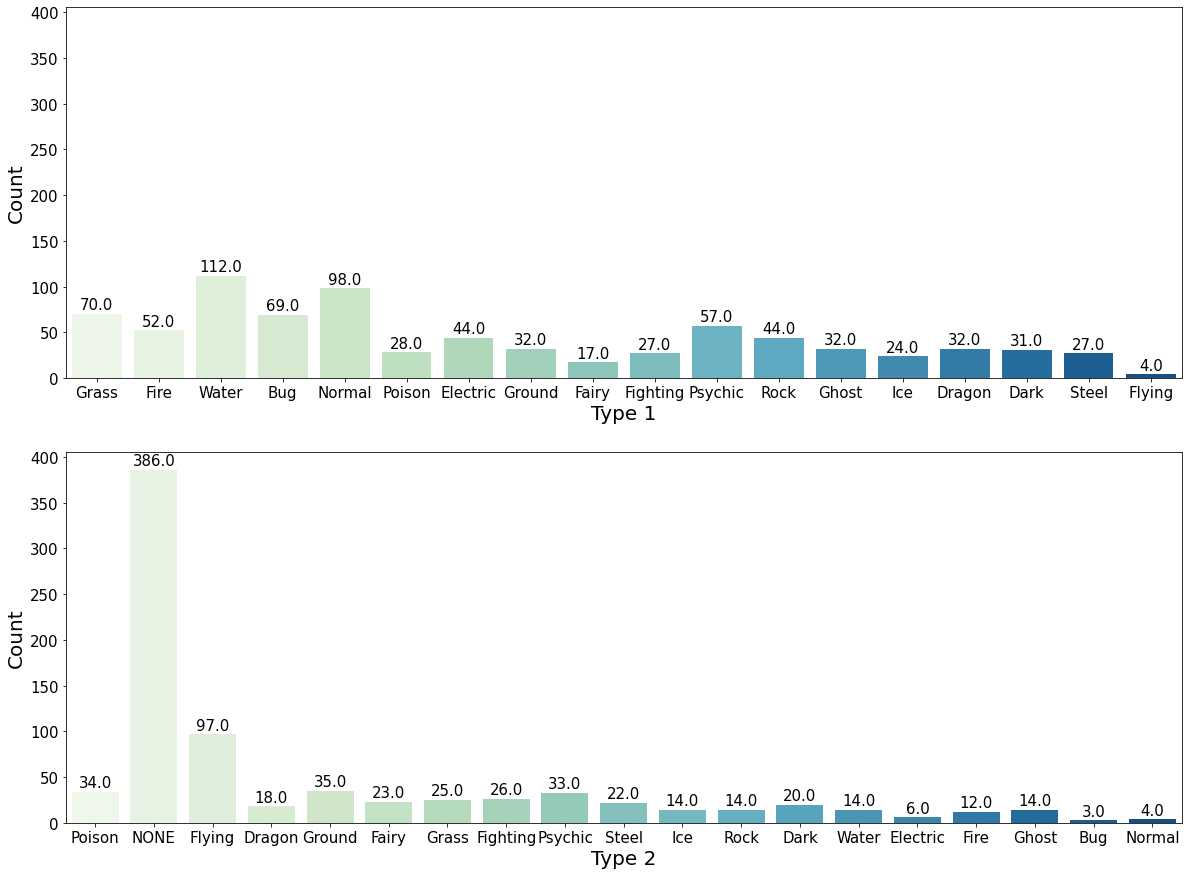

In [80]:
#count the number of each label 
label_feature = label_data.columns
f, axes = plt.subplots(2,1, figsize=(20,15), sharey = True) 
k = 0
for i in range(0,2):
    s = sns.countplot(x = label_feature[k], data = label_data, ax=axes[i], 
                      palette = 'GnBu')
    axes[i].set_xlabel(label_feature[k], fontsize=20)
    axes[i].set_ylabel("Count", fontsize=20)
    axes[i].tick_params(labelsize=15)
    k = k+1
    for p in s.patches:
        s.annotate(format(p.get_height(), '.1f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, 9), 
        fontsize = 15,
        textcoords = 'offset points')
plt.savefig('./image/CountLabel.png')   

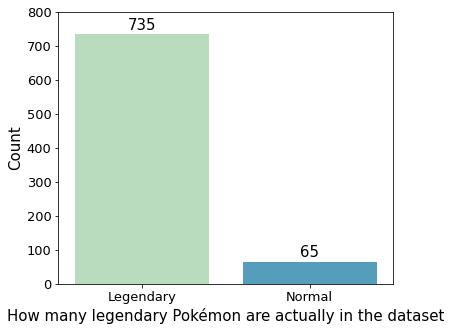

In [81]:
#count the number of legendary Pokémon
f, axes = plt.subplots(1,1,figsize=(6,5), sharey = True) 
s = sns.countplot(x = label_feature[2], data = label_data, ax=axes, palette = 'GnBu')
axes.set_xlabel('How many legendary Pokémon are actually in the dataset', fontsize=15)
axes.set_ylabel("Count", fontsize=15)
axes.tick_params(labelsize=13)
axes.set(ylim=[0,800],xticks=[0,1],xticklabels=['Legendary','Normal'])
for p in s.patches:
        s.annotate(format(p.get_height()), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, 9), 
        fontsize = 15,
        textcoords = 'offset points')

plt.savefig('./image/CountLegendary.png')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

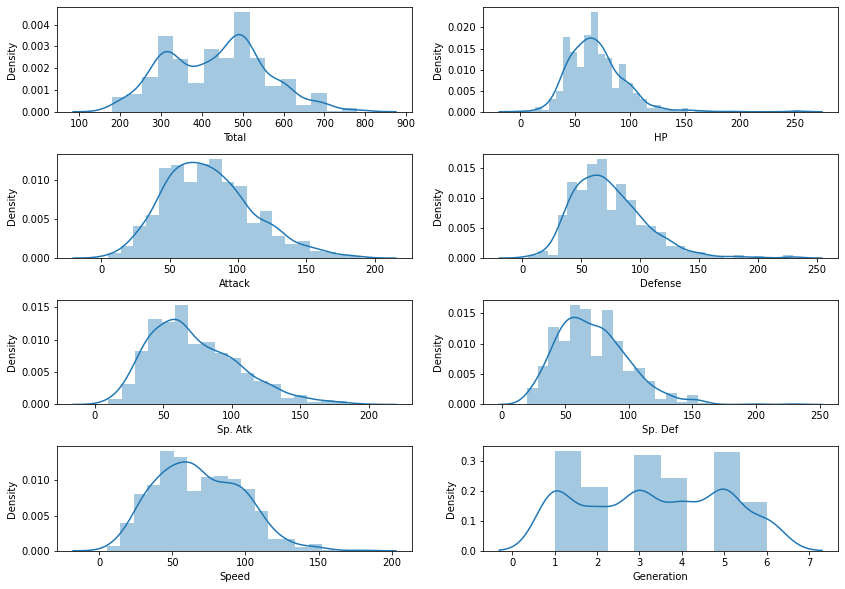

In [82]:
#plot the Distribution density of different numerical data
col = num_data.columns
f = plt.figure(figsize=(14,10))
f.subplots_adjust(hspace=0.4)
for i in range (1,9):
    f.add_subplot(4,2,i)
    sns.distplot(num_data[col[i-1]],hist=True)
    
plt.savefig('./image/DistributionDensity.png')

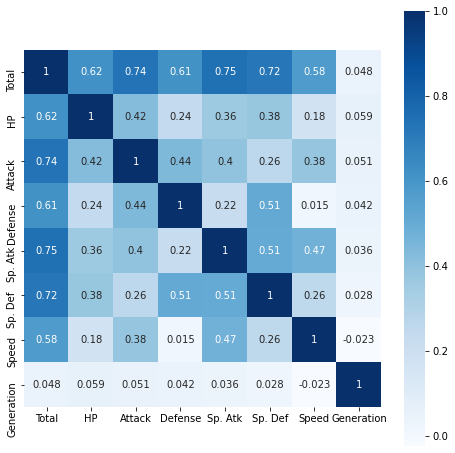

In [83]:
#plot the correlation coefficient matrix of numerical data
correlations = num_data.corr() 
plt.subplots(figsize=(8, 8))
sns.heatmap(correlations, annot=True, vmax=1, square=True, cmap="Blues")

plt.savefig('./image/Correlation.png')
plt.show()

## Processing the dataset

In [85]:
#split train/test set
x_train, x_test, y_train, y_test = train_test_split(features, target,test_size = 0.3,random_state = 0)

In [86]:
#over-sampling the train set
sm = SMOTE(random_state=0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
print(y_train_res.value_counts())

Legendary
True         518
False        518
dtype: int64


## The random forest algorithm

### Tuning hyperparameters

In [151]:
#build the random forest model
#find the best n_estimators
score = [] 
for i in range(10,200,10):

    rfc = RandomForestClassifier(n_estimators=i+1, random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    score.append(acc) 
    
print(max(score),(score.index(max(score))*10)+1)

0.9583333333333334 101


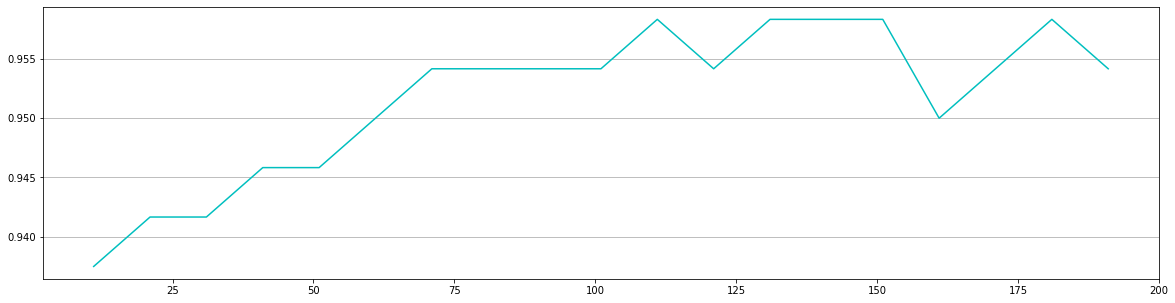

In [111]:
plt.figure(figsize=[20,5]) 
plt.grid(axis="y")
plt.plot(range(11,201,10),score,color='c') 
plt.savefig('./image/n_estimators_1.png')
plt.show()

In [112]:
#in the last step, we find the best n_estimators in 95~105,now we find the exact value
score = [] 
for i in range(95,105):
    
    rfc = RandomForestClassifier(n_estimators=i+1, random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    
    score.append(acc) 
print(max(score),([*range(95,105)][score.index(max(score))]))

0.9583333333333334 95


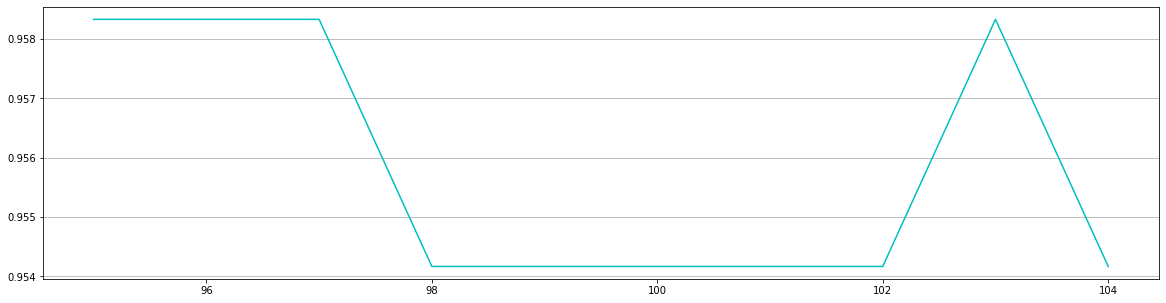

In [113]:
plt.figure(figsize=[20,5]) 
plt.grid(axis="y")
plt.plot(range(95,105),score,color='c') 

plt.savefig('./image/n_estimators_2.png')
plt.show()

In [147]:
#tune the max_depth
score = [] 
for i in range(1,20):
    
    rfc = RandomForestClassifier(max_depth=i+1,n_estimators=95, random_state=0,oob_score=True)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    score.append(acc) 
    
print(max(score),([*range(1,20)][score.index(max(score))]))

0.9541666666666667 14


In [115]:
#tune the max_features
score = [] 
for i in range(5,30):
    
    
    rfc = RandomForestClassifier(max_features=i+1,max_depth=14,n_estimators=95, random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    
    score.append(acc) 
print(max(score),([*range(5,30)][score.index(max(score))]))

0.9541666666666667 6


In [116]:
#tune the min_samples_split
score = [] 
for i in range(2,22):
    
    rfc = RandomForestClassifier(min_samples_split=i+1,max_features=6,max_depth=14,n_estimators=95, random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    
    score.append(acc) 
print(max(score),([*range(2,22)][score.index(max(score))]))

0.9541666666666667 5


### Using the best RF model to perform experiment

accuracy: 0.9416666666666667
OBB: 0.9806949806949807


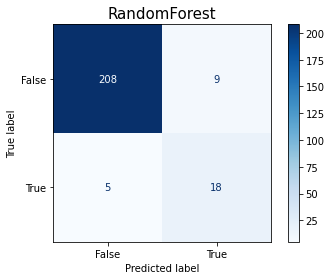

In [155]:
#use the best model
RF = RandomForestClassifier(min_samples_split=5,max_features=6,max_depth=14,n_estimators=95, random_state=0,oob_score=True)
RF.fit(x_train_res, y_train_res.values.ravel())
RF_pre = RF.predict(x_test)
RF_acc = accuracy_score(y_test,RF_pre)
RF_proba = RF.predict_proba(x_test)
RF_obb = RF.oob_score_
print("accuracy:",RF_acc)
print("OBB:",RF_obb)
plot_confusion_matrix(RF, x_test, y_test,cmap='Blues') 
plt.title('RandomForest',fontsize=15)

plt.savefig('./image/RF_confusion.png')
plt.show()

In [130]:
#use 10 fold cross validation with SMOTE in each fold
RF = RandomForestClassifier(min_samples_split=5,max_features=6,max_depth=14,n_estimators=95, random_state=0)
kf = KFold(n_splits=10)
index = kf.split(X=features,y=target)
X=features
y=target
RF_acc_cross=[]
for fold, (train_index, test_index) in enumerate(index):
    c_X_train = X.iloc[train_index]
    c_y_train = y.iloc[train_index].values.ravel()  
    c_X_test = X.iloc[test_index]
    c_y_test = y.iloc[test_index].values.ravel()  
    sm = SMOTE(random_state=100)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(c_X_train, c_y_train)
    model = RF  
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(c_X_test)
    acc=model.score(c_X_test, c_y_test)
    RF_acc_cross.append(acc)
score = np.mean(RF_acc_cross)

print("mean accuracy:",score)
print("10 fold accuracy:",RF_acc_cross)

mean accuracy: 0.9337500000000001
10 fold accuracy: [0.925, 0.975, 0.9625, 0.8875, 0.975, 0.875, 0.8875, 1.0, 0.9125, 0.9375]


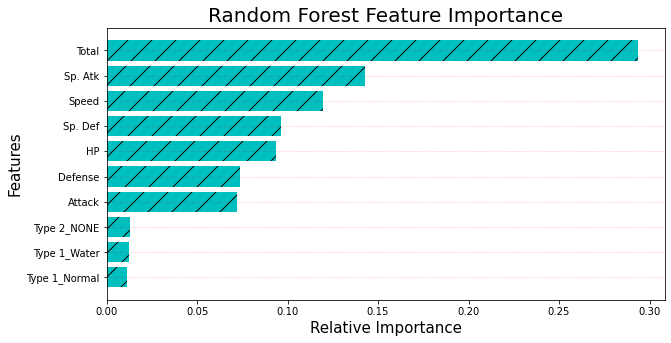

,44,43,42,41,40,39,38,37,36,35
0,Total,Sp. Atk,Speed,Sp. Def,HP,Defense,Attack,Type 2_NONE,Type 1_Water,Type 1_Normal
1,0.293622,0.142584,0.119388,0.0965012,0.0935114,0.0738401,0.0721877,0.0130434,0.0124685,0.0113544


In [119]:
#caculate and visualize the relative importance of every feature in this RF model
importances = list(RF.feature_importances_)  
feature_list = features.columns
feature_importances = list(zip(feature_list,importances))
feature_importances = sorted(feature_importances, key =lambda x:x[1], reverse = False)
feature_importances = list(zip(*feature_importances))
top = pd.DataFrame(feature_importances).iloc[:,-10:]

name=top.loc[0]
value=top.loc[1]


plt.figure(figsize=(10,5))
plt.barh(name,value,color="c",hatch="/",height=0.8)
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Random Forest Feature Importance',fontsize=20)
plt.grid(True, axis="y",ls=":",color="r",alpha=0.3)

plt.savefig('./image/RF_importance.png')
plt.show()
pd.DataFrame(top).sort_index(axis = 1,ascending = False)

## The decision tree algorithm

### Tuning hyperparameters

In [120]:
#build the single dicision tree model 
#tune the max_depth
score = [] 
for i in range(1,20):
    
    rfc = DecisionTreeClassifier(max_depth=i+1,random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    
    score.append(acc) 
print(max(score),([*range(1,20)][score.index(max(score))]))

0.9583333333333334 15


In [121]:
#tune the max_features
score = [] 
for i in range(5,30):
    
    rfc = DecisionTreeClassifier(max_features=i+1,max_depth=15,random_state=0)
    rfc.fit(x_train_res, y_train_res.values.ravel())
    rfc_pre = rfc.predict(x_test)
    acc = accuracy_score(y_test,rfc_pre)
    
    score.append(acc) 
print(max(score),([*range(5,30)][score.index(max(score))]))

0.95 7


### Using the best DT model to perform experiment

accuracy: 0.925


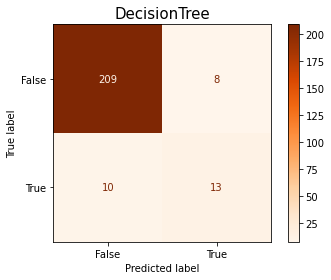

In [122]:
#use the best model
DT = DecisionTreeClassifier(max_features=7,max_depth=15,random_state=0)
DT = DT.fit(x_train_res, y_train_res.values.ravel())
DT_pre = DT.predict(x_test)
DT_acc = accuracy_score(y_test,DT_pre)
DT_proba = DT.predict_proba(x_test)
print("accuracy:",DT_acc)
plot_confusion_matrix(DT, x_test, y_test,cmap='Oranges') 
plt.title('DecisionTree',fontsize=15)
plt.savefig('./image/DT_confusion.png')
plt.show()

In [129]:
#use 10 fold cross validation with SMOTE in each fold
DT = DecisionTreeClassifier(max_features=7,max_depth=15,random_state=0)
kf = KFold(n_splits=10)
index = kf.split(X=features,y=target)
X=features
y=target
DT_acc_cross=[]
for fold, (train_index, test_index) in enumerate(index):
    c_X_train = X.iloc[train_index]
    c_y_train = y.iloc[train_index].values.ravel()  
    c_X_test = X.iloc[test_index]
    c_y_test = y.iloc[test_index].values.ravel()  
    sm = SMOTE(random_state=100)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(c_X_train, c_y_train)
    model = DT  
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(c_X_test)
    acc=model.score(c_X_test, c_y_test)
    DT_acc_cross.append(acc)
score = np.mean(DT_acc_cross)

print("mean accuracy:",score)
print("10 fold accuracy:",RF_acc_cross)

mean accuracy: 0.9125
10 fold accuracy: [0.925, 0.975, 0.9625, 0.8875, 0.975, 0.875, 0.8875, 1.0, 0.9125, 0.9375]


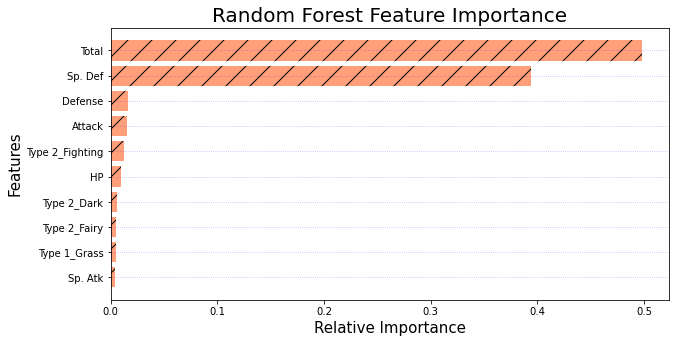

,44,43,42,41,40,39,38,37,36,35
0,Total,Sp. Def,Defense,Attack,Type 2_Fighting,HP,Type 2_Dark,Type 2_Fairy,Type 1_Grass,Sp. Atk
1,0.498213,0.393685,0.0167672,0.0154918,0.0126044,0.00988179,0.00573138,0.00536268,0.00477795,0.0045939


In [124]:
#caculate and visualize the relative importance of every feature in this DT model
importances = list(DT.feature_importances_)  
feature_list = features.columns
feature_importances = list(zip(feature_list,importances))
feature_importances = sorted(feature_importances, key =lambda x:x[1], reverse = False)
feature_importances = list(zip(*feature_importances))
top = pd.DataFrame(feature_importances).iloc[:,-10:]

name=top.loc[0]
value=top.loc[1]


plt.figure(figsize=(10,5))
plt.barh(name,value,color="lightsalmon",hatch="/",height=0.8)
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Random Forest Feature Importance',fontsize=20)
plt.grid(True, axis="y",ls=":",color="b",alpha=0.3)
plt.savefig('./image/DT_importance.png')
plt.show()
pd.DataFrame(top).sort_index(axis = 1,ascending = False)

## Evaluating and comparing two models

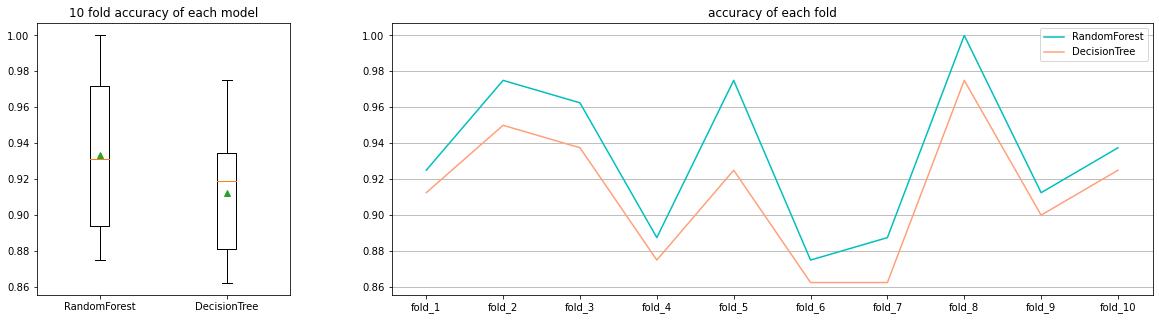

In [126]:
#evaluate two models 
# draw cross validation results 
plotdata= [RF_acc_cross,DT_acc_cross]
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])

box = fig.add_subplot(gs[0])
box.boxplot(plotdata,showmeans=True)
box.set(title='10 fold accuracy of each model')
plt.setp([box],xticks=[1,2],xticklabels=['RandomForest', 'DecisionTree'])

line = fig.add_subplot(gs[1])
x=[0,1,2,3,4,5,6,7,8,9];
line.set(title='accuracy of each fold')
line.plot(x,plotdata[0],color = 'c')
line.plot(x,plotdata[1],color = 'lightsalmon')
line.grid(axis="y")
plt.setp([line],xticks=[0,1,2,3,4,5,6,7,8,9]
          ,xticklabels=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 
                         'fold_6', 'fold_7', 'fold_8', 'fold_9', 'fold_10'])
plt.legend(labels = ['RandomForest', 'DecisionTree'],loc ='best')

plt.savefig('./image/CrossValidation.png')

In [127]:
#caculate auc
RF_fpr, RF_tpr, RF_thresholds  =  roc_curve(y_test, RF_proba[:, 1]) 
RF_roc_auc = auc(RF_fpr,RF_tpr)

RF_precision, RF_recall, RF_pthresholds = precision_recall_curve(y_test, RF_proba[:, 1])
RF_pr_auc = auc(RF_recall, RF_precision)



DT_fpr, DT_tpr, DT_thresholds  =  roc_curve(y_test, DT_proba[:, 1]) 
DT_roc_auc = auc(DT_fpr,DT_tpr)

DT_precision, DT_recall, DT_pthresholds = precision_recall_curve(y_test, DT_proba[:, 1])
DT_pr_auc = auc(DT_recall, DT_precision)

print(RF_roc_auc)
print(DT_roc_auc)

0.9789621318373072
0.7641755159286716


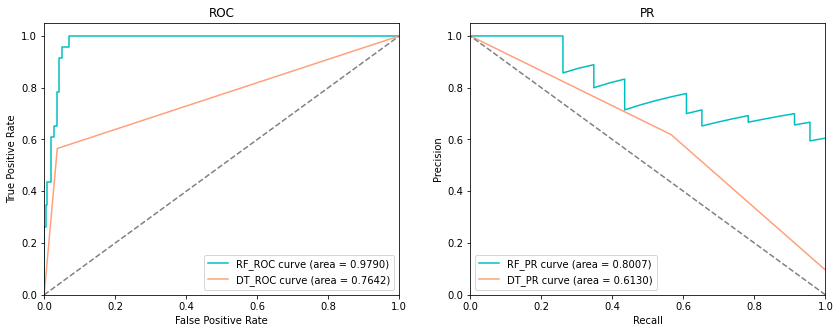

In [128]:
fig = plt.figure(figsize=(14,5))
roc = fig.add_subplot(121)
pr = fig.add_subplot(122)

roc.plot(RF_fpr, RF_tpr, color='c',
         label='RF_ROC curve (area = %0.4f)' % RF_roc_auc) 
roc.plot(DT_fpr, DT_tpr, color='lightsalmon',
         label='DT_ROC curve (area = %0.4f)' % DT_roc_auc)
roc.plot([0, 1], [0, 1], color='grey', linestyle='--')
roc.set(xlim=[0.0,1.0],ylim=[0.0,1.05],xlabel='False Positive Rate',
        ylabel='True Positive Rate',title='ROC')
roc.legend(loc="lower right")



pr.plot(RF_recall, RF_precision, color='c',
         label='RF_PR curve (area = %0.4f)' % RF_pr_auc) 
pr.plot(DT_recall, DT_precision,  color='lightsalmon',
         label='DT_PR curve (area = %0.4f)' % DT_pr_auc)
pr.plot([1, 0], [0, 1], color='grey',linestyle='--')
pr.set(xlim=[0.0,1.0],ylim=[0.0,1.05],xlabel='Recall',
        ylabel='Precision',title='PR')
pr.legend(loc="lower left")

plt.savefig('./image/ROCandPR.png')
plt.show()